# **Introduction**


---


measure the satisfaction of customers so that it could use it as a performance indicator to assess the quality of services, which will be done through capturing images of the faces of its customers and feeding them to trained models which are constructed using deep learning algorithms.













# **Import and Install Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip data/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import cv2
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from datetime import datetime
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet169



# **Load Data**

In [4]:
train_dir = 'data/train/'
test_dir ='data/test/'

# **EDA**

In [6]:
row, col = 48, 48
classes = 7

#make a count of the different classes
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       fear   sad  surprise  neutral  angry  disgust  happy
train  4097  4830      3171     4965   3995      436   7215
      fear   sad  surprise  neutral  angry  disgust  happy
test  1024  1247       831     1233    958      111   1774


In [7]:
#define a function to plot some images from different classes

def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='Blues_r')

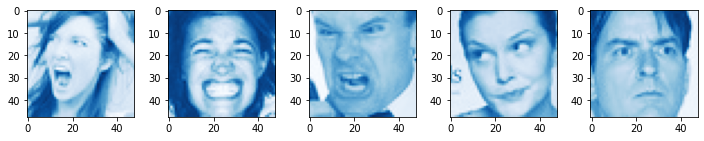

In [8]:
#angry class
plot_images(train_dir+'/angry')

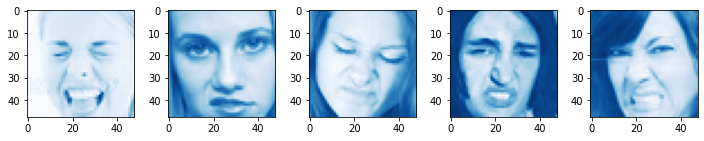

In [9]:
#disgust class
plot_images(train_dir+'/disgust')

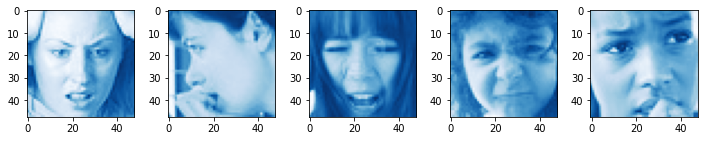

In [10]:
#fear class
plot_images(train_dir+'/fear')

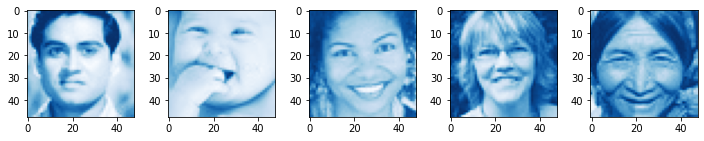

In [11]:
#happy class
plot_images(train_dir+'/happy')

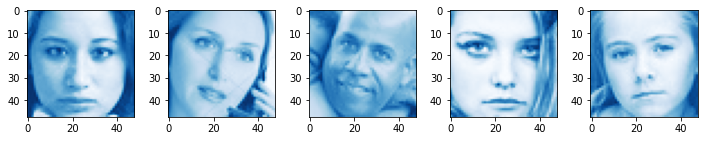

In [12]:
#neutral class
plot_images(train_dir+'/neutral')

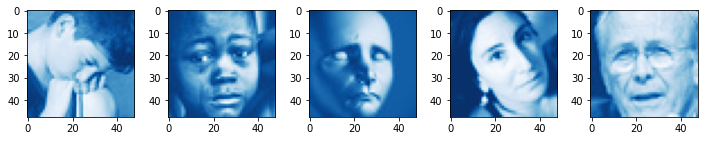

In [13]:
#sad class
plot_images(train_dir+'/sad')

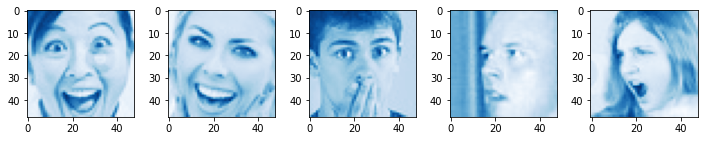

In [14]:
#surprise class
plot_images(train_dir+'/surprise')

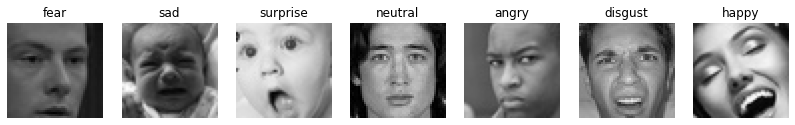

In [15]:
#plot some from the test set


plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((test_dir + expression +'/'+ os.listdir(test_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# **Initialize the training and validation generators:**

In [16]:

train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48,48),
                                                    batch_size = 32,
                                                    color_mode ='rgb',
                                                    class_mode = "categorical"
                                                   )
test_generator = test_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (48,48),
                                                              batch_size = 32,
                                                               color_mode ='rgb',
                                                              class_mode = "categorical"
                                                             )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Build the convolution network architecture:**

## DenseNet169 architecture


In [17]:
#using pretrained model, DenseNet169 architecture

DenseNet_base_model = DenseNet169(input_shape=(48,48,3),include_top = False, weights = 'imagenet')
DenseNet_base_model.summary()

51888128/51877672 [==============================] - 1s 0us/step
Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 24, 24, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1/conv[0][0]']             
                       

In [18]:
# Freezing layers 
for layer in DenseNet_base_model.layers[:-4]:
    layer.trainable = False

## Building the Convolutional Neural Network (CNN) Model:

In [19]:
# Build model on the top of base model
model = Sequential()

model.add(DenseNet_base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())

#add fully connected layers
model.add(Dense(512,activation ='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax')) #output layer

In [20]:
# model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 1, 1, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 batch_normalization (BatchN  (None, 1664)             6656      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               852480    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [21]:
#import modules that will wnable early stopping for optimization during model training
#tensorboard
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

#define the early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

## **Compile and train the model:**

In [22]:
# compile model
model.compile(optimizer='adam', # optimize the model with adam optimizer
              loss="categorical_crossentropy", #for svm classification
              metrics=['accuracy']) #to get accuracy of the model in each run

In [23]:
#fit the model on train data and add val data fro validation
history = model.fit(train_generator,
    batch_size = 32,
    verbose = 1, # Suppress chatty output; use Tensorboard instead
    epochs = 50, #add the validation set to evaluate the performance in each run
    validation_data = test_generator
)

Epoch 1/50
898/898 [==============================] - 104s 92ms/step - loss: 2.4224 - accuracy: 0.3128 - val_loss: 1.8649 - val_accuracy: 0.3806
Epoch 2/50
898/898 [==============================] - 77s 86ms/step - loss: 1.9242 - accuracy: 0.3308 - val_loss: 1.8176 - val_accuracy: 0.3802
Epoch 3/50
898/898 [==============================] - 77s 86ms/step - loss: 1.8879 - accuracy: 0.3357 - val_loss: 1.8282 - val_accuracy: 0.3667
Epoch 4/50
898/898 [==============================] - 77s 86ms/step - loss: 1.8648 - accuracy: 0.3392 - val_loss: 1.7860 - val_accuracy: 0.3817
Epoch 5/50
898/898 [==============================] - 77s 86ms/step - loss: 1.8480 - accuracy: 0.3437 - val_loss: 1.7699 - val_accuracy: 0.3725
Epoch 6/50
898/898 [==============================] - 77s 86ms/step - loss: 1.8216 - accuracy: 0.3521 - val_loss: 1.7565 - val_accuracy: 0.3904
Epoch 7/50
898/898 [==============================] - 77s 86ms/step - loss: 1.8022 - accuracy: 0.3514 - val_loss: 1.7411 - val_accuracy

## **Saving The Model**

In [24]:
#model.save('/drive/MyDrive/DL/model1.h5')
#model.save_weights('drive/MyDrive/DL/model1.h5')
model.save('/content/drive/MyDrive/DL')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/assets


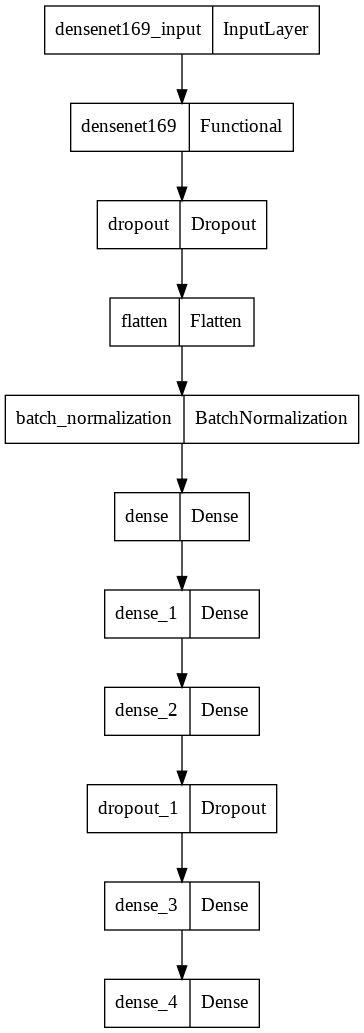

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model)

Text(0.5, 1.0, 'Training and Validation Accuracy')

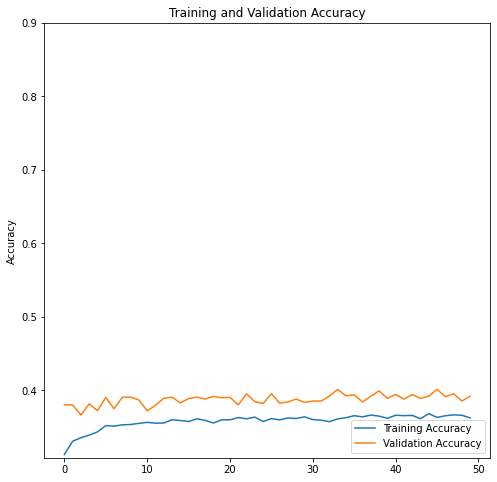

In [26]:
acc = history.history['accuracy'] # get history report of the model

val_acc = history.history['val_accuracy'] # get history of the validation set

loss = history.history['loss'] #get the history of the lossses recorded on the train set
val_loss = history.history['val_loss'] #get the history of the lossses recorded on the validation set

plt.figure(figsize=(8, 8)) # set figure size for the plot generated


plt.plot(acc, label='Training Accuracy') #plot accuracy curve for each train run
plt.plot(val_acc, label='Validation Accuracy') #plot accuracy curve for each validation run

plt.legend(loc='lower right')
plt.ylabel('Accuracy') #label name for y axis
plt.ylim([min(plt.ylim()),0.9]) #set limit for y axis
plt.title('Training and Validation Accuracy') #set title for the plot

In [27]:
# Unfreeze the base model
DenseNet_base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer= Adam(1e-5),  # Very low learning rate
              loss="categorical_crossentropy", #for svm classification
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
history1 = model.fit(train_generator,
    batch_size = 32,
    verbose = 1, # Suppress chatty output; use Tensorboard instead
    epochs = 25, #add the validation set to evaluate the performance in each run
    callbacks = [tensorboard_callback, es],
    validation_data = test_generator
)

Epoch 1/25
898/898 [==============================] - 188s 184ms/step - loss: 1.7643 - accuracy: 0.3067 - val_loss: 1.6747 - val_accuracy: 0.3639
Epoch 2/25
898/898 [==============================] - 160s 179ms/step - loss: 1.6619 - accuracy: 0.3634 - val_loss: 1.5754 - val_accuracy: 0.4120
Epoch 3/25
898/898 [==============================] - 160s 179ms/step - loss: 1.5904 - accuracy: 0.4027 - val_loss: 1.5124 - val_accuracy: 0.4487
Epoch 4/25
898/898 [==============================] - 160s 178ms/step - loss: 1.5341 - accuracy: 0.4262 - val_loss: 1.4456 - val_accuracy: 0.4756
Epoch 5/25
898/898 [==============================] - 160s 178ms/step - loss: 1.4847 - accuracy: 0.4493 - val_loss: 1.4034 - val_accuracy: 0.4872
Epoch 6/25
898/898 [==============================] - 160s 178ms/step - loss: 1.4427 - accuracy: 0.4679 - val_loss: 1.3574 - val_accuracy: 0.5049
Epoch 7/25
898/898 [==============================] - 168s 187ms/step - loss: 1.4092 - accuracy: 0.4787 - val_loss: 1.3386 -




## **Saving The Unfreeze base Model**

In [28]:
#model.save('/drive/MyDrive/model2.h5')
model.save('/content/drive/MyDrive/DL')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/assets


Text(0.5, 1.0, 'Training and Validation Accuracy')

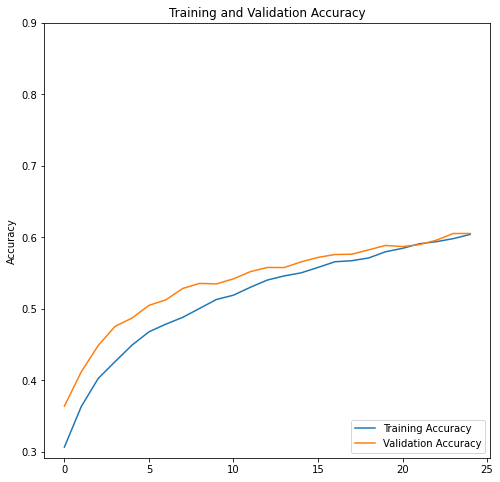

In [29]:
acc = history1.history['accuracy'] # get history report of the model

val_acc = history1.history['val_accuracy'] # get history of the validation set

loss = history1.history['loss'] #get the history of the lossses recorded on the train set
val_loss = history1.history['val_loss'] #get the history of the lossses recorded on the validation set

plt.figure(figsize=(8, 8)) # set figure size for the plot generated


plt.plot(acc, label='Training Accuracy') #plot accuracy curve for each train run
plt.plot(val_acc, label='Validation Accuracy') #plot accuracy curve for each validation run

plt.legend(loc='lower right')
plt.ylabel('Accuracy') #label name for y axis
plt.ylim([min(plt.ylim()),0.9]) #set limit for y axis
plt.title('Training and Validation Accuracy') #set title for the plot

## RESNET50 architecture

In [30]:
#using pretrained model, RESNET50 architecture
RESNET50_base_model = ResNet50(input_shape=(48,48,3),include_top = False, weights = 'imagenet')
RESNET50_base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                          

In [32]:
# Freezing layers 
for layer in RESNET50_base_model.layers[:-4]:
    layer.trainable = False


## Building the Convolutional Neural Network (CNN) Model:

In [33]:
# Build model on the top of base model RESNET50
model2 = Sequential()

model2.add(RESNET50_base_model)
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(BatchNormalization())

#add fully connected layers
model2.add(Dense(512,activation ='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(rate = 0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(7, activation='softmax')) #output layer

In [34]:
# model Summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 512)               4194816   
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                      

In [35]:
#import modules that will wnable early stopping for optimization during model training
#tensorboard
logdir2 = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback2 = TensorBoard(log_dir=logdir2)

#define the early stopping
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

## **Compile and train the model:**



In [36]:
# compile model
model2.compile(optimizer='adam', # optimize the model with adam optimizer
              loss="categorical_crossentropy", #for svm classification
              metrics=['accuracy']) #to get accuracy of the model in each run

In [37]:
#fit the model on train data and add val data fro validation
history2 = model2.fit(train_generator,
    batch_size = 32,
    verbose = 1, # Suppress chatty output; use Tensorboard instead
    epochs = 50, #add the validation set to evaluate the performance in each run
    validation_data = test_generator
)

Epoch 1/50
898/898 [==============================] - 75s 78ms/step - loss: 2.4426 - accuracy: 0.2448 - val_loss: 2.1303 - val_accuracy: 0.2451
Epoch 2/50
898/898 [==============================] - 64s 71ms/step - loss: 2.0193 - accuracy: 0.2577 - val_loss: 2.1261 - val_accuracy: 0.1757
Epoch 3/50
898/898 [==============================] - 64s 72ms/step - loss: 1.9911 - accuracy: 0.2603 - val_loss: 1.9455 - val_accuracy: 0.2751
Epoch 4/50
898/898 [==============================] - 64s 71ms/step - loss: 1.9726 - accuracy: 0.2657 - val_loss: 1.9599 - val_accuracy: 0.2609
Epoch 5/50
898/898 [==============================] - 64s 72ms/step - loss: 1.9444 - accuracy: 0.2643 - val_loss: 1.9508 - val_accuracy: 0.2615
Epoch 6/50
898/898 [==============================] - 64s 72ms/step - loss: 1.9248 - accuracy: 0.2674 - val_loss: 1.9946 - val_accuracy: 0.2568
Epoch 7/50
898/898 [==============================] - 64s 71ms/step - loss: 1.8986 - accuracy: 0.2701 - val_loss: 1.9142 - val_accuracy:

## Saving The Model

In [38]:
model2.save('/content/drive/MyDrive/DL')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/assets


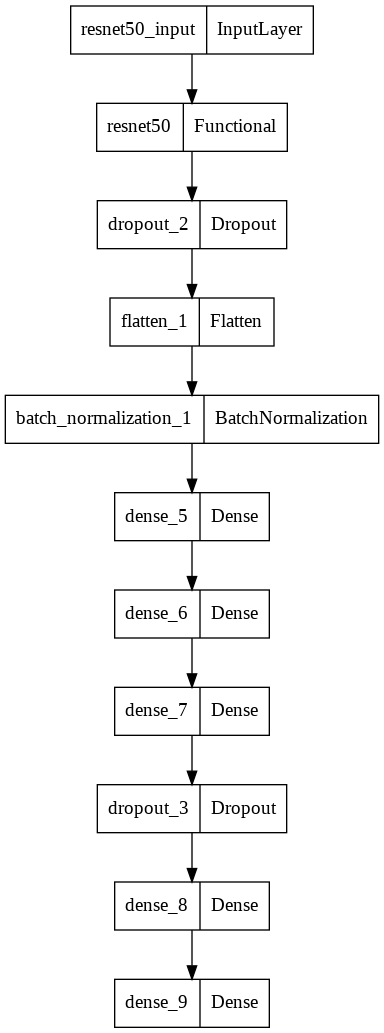

In [39]:
from keras.utils.vis_utils import plot_model
plot_model(model2)

Text(0.5, 1.0, 'Training and Validation Accuracy')

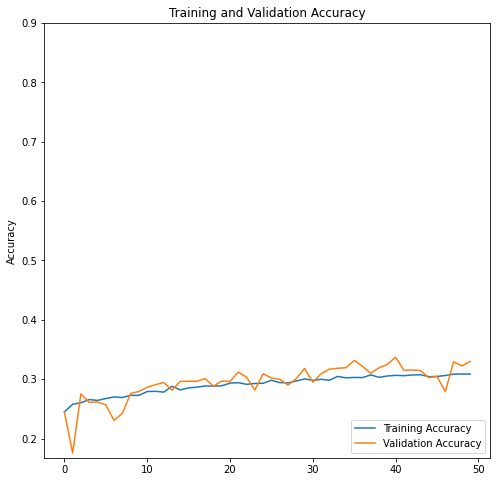

In [40]:
acc2 = history2.history['accuracy'] # get history report of the model

val_acc2 = history2.history['val_accuracy'] # get history of the validation set

loss2 = history2.history['loss'] #get the history of the lossses recorded on the train set
val_loss2 = history2.history['val_loss'] #get the history of the lossses recorded on the validation set

plt.figure(figsize=(8, 8)) # set figure size for the plot generated


plt.plot(acc2, label='Training Accuracy') #plot accuracy curve for each train run
plt.plot(val_acc2, label='Validation Accuracy') #plot accuracy curve for each validation run

plt.legend(loc='lower right')
plt.ylabel('Accuracy') #label name for y axis
plt.ylim([min(plt.ylim()),0.9]) #set limit for y axis
plt.title('Training and Validation Accuracy') #set title for the plot

In [44]:
# Unfreeze the base model
RESNET50_base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model2.compile(optimizer= Adam(1e-5),  # Very low learning rate
              loss="categorical_crossentropy", #for svm classification
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
history3 = model2.fit(train_generator,
    batch_size = 32,
    verbose = 1, # Suppress chatty output; use Tensorboard instead
    epochs = 25, #add the validation set to evaluate the performance in each run
    callbacks = [tensorboard_callback2, es2],
    validation_data = test_generator
)

Epoch 1/25
898/898 [==============================] - 129s 134ms/step - loss: 1.8331 - accuracy: 0.2488 - val_loss: 1.9473 - val_accuracy: 0.2452
Epoch 2/25
898/898 [==============================] - 119s 132ms/step - loss: 1.7476 - accuracy: 0.3014 - val_loss: 1.7060 - val_accuracy: 0.3434
Epoch 3/25
898/898 [==============================] - 119s 133ms/step - loss: 1.6867 - accuracy: 0.3399 - val_loss: 1.6551 - val_accuracy: 0.3780
Epoch 4/25
898/898 [==============================] - 119s 132ms/step - loss: 1.6379 - accuracy: 0.3684 - val_loss: 1.5941 - val_accuracy: 0.4071
Epoch 5/25
898/898 [==============================] - 119s 133ms/step - loss: 1.5964 - accuracy: 0.3913 - val_loss: 1.5467 - val_accuracy: 0.4315
Epoch 6/25
898/898 [==============================] - 119s 133ms/step - loss: 1.5562 - accuracy: 0.4072 - val_loss: 1.5056 - val_accuracy: 0.4408
Epoch 7/25
898/898 [==============================] - 119s 133ms/step - loss: 1.5180 - accuracy: 0.4260 - val_loss: 1.4791 -

## Saving The Unfreeze base Model

In [45]:
model2.save('/content/drive/MyDrive/DL')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/assets


Text(0.5, 1.0, 'Training and Validation Accuracy')

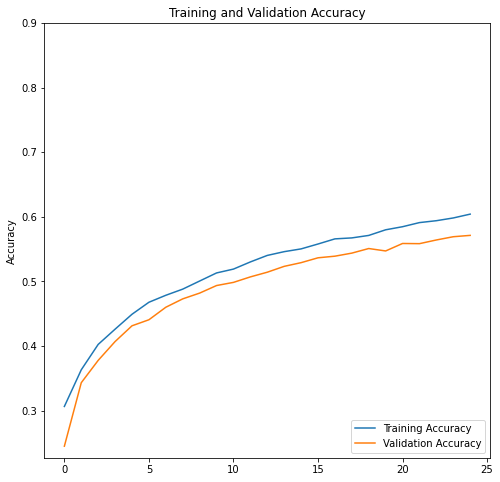

In [47]:
acc2 = history3.history['accuracy'] # get history report of the model

val_acc2 = history3.history['val_accuracy'] # get history of the validation set

loss2 = history3.history['loss'] #get the history of the lossses recorded on the train set
val_loss2 = history3.history['val_loss'] #get the history of the lossses recorded on the validation set

plt.figure(figsize=(8, 8)) # set figure size for the plot generated


plt.plot(acc, label='Training Accuracy') #plot accuracy curve for each train run
plt.plot(val_acc2, label='Validation Accuracy') #plot accuracy curve for each validation run

plt.legend(loc='lower right')
plt.ylabel('Accuracy') #label name for y axis
plt.ylim([min(plt.ylim()),0.9]) #set limit for y axis
plt.title('Training and Validation Accuracy') #set title for the plot

# **Result**

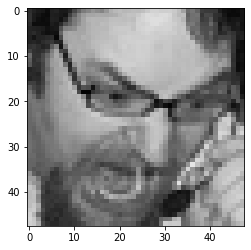

In [56]:
test_img = image.load_img('/content/data/test/angry/PrivateTest_10131363.jpg',target_size = (48,48))
plt.imshow(test_img)

In [49]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

test_img = np.expand_dims(test_img,axis = 0)
test_img = test_img.reshape(1,48, 48,3)
result = model.predict(test_img)
result = list(result[0])

img_index = result.index(max(result))
print(label_dict[img_index])

Angry


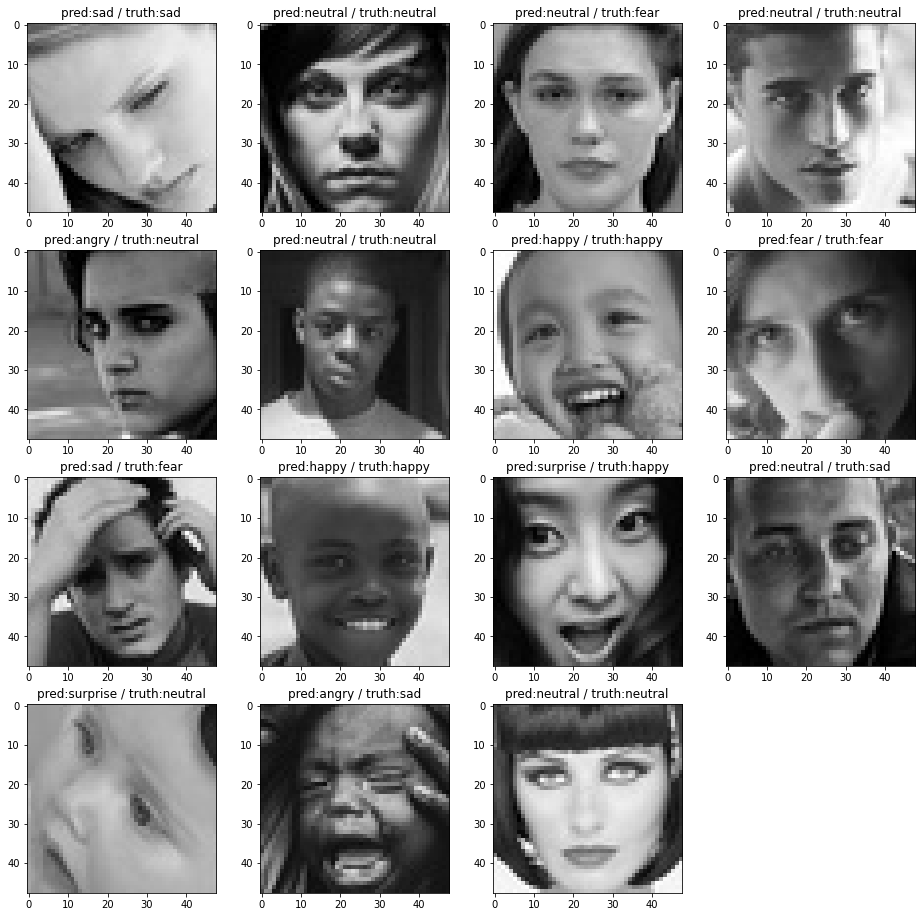

In [57]:
test_x, test_y = test_generator.__getitem__(1)

labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(15):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])